# Fremskrivning af epidemikurven for COVID-19 i Danmark

**Dette dokument danner en eksponentiel fremskriver epidemikurven ud fra dagsaktuelle tal for smittede,
 indlagt og døde.**

*Koden til denne notebook findes på GitHub, se [github.com COVID-19-dk](https://github.com/covid-19-sim/covid-19-dk)*

## Metode
Vi anvender eksponentiel fremskrivning.

Det er en meget grovkornet metode, som kun kan bruges til kortsigtede fremskrivninger, da den ikke tager højde for
at epidemien over tid har færre og færre raske at ramme (dvs. at kurven begynder at bue nedad).

Den er dog relevant, da det er en fin måde at vise data på i starten af epidemien og få en idé om den aktuelle vækstrate.

## Datagrundlag

Data er indhentet fra Sundhedsstyrelsens hjemmeside for 
[COVID-19 tal og overvågning](https://www.sst.dk/da/corona/tal-og-overvaagning).

Læs mere om datasættet på https://github.com/covid-19-sim/covid-19.sst.dk

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.optimize

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/covid-19-sim/covid-19.sst.dk/master/total-covid-19-dk.csv',
                 parse_dates=['Date'])

df.head(1000)

,Date,Tested,Total tested,Confirmed,Total confirmed,Hospitalised,ICU,ICU-vent,Deaths,Total deaths
0,2020-03-03,508,508,13,13,NaN,NaN,NaN,NaN,NaN
1,2020-03-04,84,592,3,16,NaN,NaN,NaN,NaN,NaN
2,2020-03-05,93,685,10,26,NaN,NaN,NaN,NaN,NaN
3,2020-03-06,124,809,2,28,NaN,NaN,NaN,NaN,NaN
4,2020-03-07,103,912,9,37,NaN,NaN,NaN,NaN,NaN
5,2020-03-08,224,1136,48,85,NaN,NaN,NaN,NaN,NaN
6,2020-03-09,570,1706,210,295,NaN,NaN,NaN,NaN,NaN
7,2020-03-10,796,2502,256,551,NaN,NaN,NaN,NaN,NaN
8,2020-03-11,869,3371,207,758,NaN,NaN,NaN,1.0,1.0
9,2020-03-12,661,4032,44,802,19.0,3.0,NaN,0.0,1.0


In [3]:
# Kontroller at data har det forventede format
for c in ['Date', 'Total tested', 'Total confirmed', 'Hospitalised', 'ICU', 'ICU-vent', 'Deaths', 'Total deaths']:
    assert c in df.columns    

In [4]:
# Epidemistarten er den første dato 
EPIDEMI_START = pd.Timestamp("2020-03-03")

df['Day'] = df['Date'] - EPIDEMI_START
df['Day N'] = df['Day'].dt.days


## Faktiske indlæggelser og dødsfald
Datasættet ser således ud når vi tegner graferne med henholdsvis lineær og logaritmisk y-akse.
Husk at en ret linie på logaritmisk y-akse svarer til konstant procentuel daglig tilvækst.   

In [5]:
# Udvælg data vi interesserer os for
OVERSKRIFTER = {'Hospitalised': 'Indlagte', 
                'ICU': 'Intensiv', 
                'ICU-vent': 'Intensiv med respirator', 
                'Total deaths': 'Døde'}

kolonner = list(OVERSKRIFTER.keys())

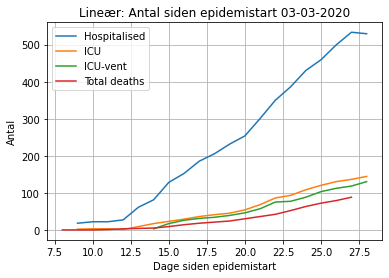

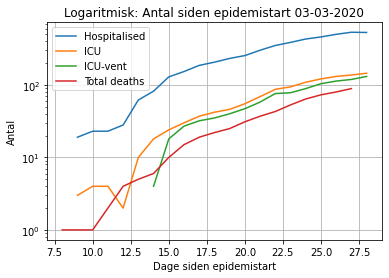

In [6]:
for is_log_plot, titel in [[False, "Lineær"], [True, "Logaritmisk"]]:
    ax = df.plot(x='Day N', y=kolonner, grid=True, logy=is_log_plot,
            title=f'{titel}: Antal siden epidemistart {EPIDEMI_START.date().strftime("%d-%m-%Y")}')
    plt.xlabel('Dage siden epidemistart')
    plt.ylabel('Antal')
    plt.show()

## Eksponentiel fremskrivning

Vi estimerer $a$ og $b$ en simpel eksponentialfunktion til dødsfaldskurven, 

$$\hat{y} = a e^{b x}$$ 

$x$ er dage siden epidemistart, $\hat{y}$ er det estimere antal døde. 

SciPy har en indbygget funktion til at dette, `curve_fit`:

In [7]:
# Hvis ikke vi har observationen, så drop rækken
df_renset = df[['Day N'] + kolonner].dropna()

x_data = df_renset['Day N']

def exp_func(x, a, b):
    return a * np.exp(b * x)

def estimer_a_b(ys):
    """Estimer a og b baseret på alle observationer"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, x_data, ys)
    a,b = popt
    return a,b    

Vi kan også beregne en rullende prognose baseret på kun de nyeste observationer. Dette giver os mulighed for at 
se tendensen.

In [8]:
TENDENS_DAGE = 5

def estimer_tendens(ys):
    """Estimer a og b på bases af de seneste dages observationer (rullende prognose)"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, x_data[-TENDENS_DAGE:], ys[-TENDENS_DAGE:])
    a,b = popt
    return a,b    

In [9]:
# Estimer alle kolonnerne
estimater = {}

for k in kolonner:
    y_data = df_renset[k]
    a, b = estimer_a_b(y_data)
    a_tendens, b_tendens = estimer_tendens(y_data)
    overskrift = OVERSKRIFTER[k]
    print(f'{overskrift:30}: a         = {a}')
    print(f'{overskrift:30}: b         = {b}')
    print(f'{overskrift:30}: a_tendens = {a_tendens}')
    print(f'{overskrift:30}: b_tendens = {b_tendens}')
    print()
    estimater[k] = {'a': a, 'b': b, 'y_data': y_data, 
                    'a_tendens': a_tendens, 'b_tendens': b_tendens} 


Indlagte                      : a         = 27.039644347515168
Indlagte                      : b         = 0.11272636156728554
Indlagte                      : a_tendens = 64.60286228434083
Indlagte                      : b_tendens = 0.07839625700657452

Intensiv                      : a         = 3.9128094870912205
Intensiv                      : b         = 0.13509388076350806
Intensiv                      : a_tendens = 12.540129299598169
Intensiv                      : b_tendens = 0.08949280279944294

Intensiv med respirator       : a         = 2.8819453467605736
Intensiv med respirator       : b         = 0.14105852534418226
Intensiv med respirator       : a_tendens = 7.5140482934200135
Intensiv med respirator       : b_tendens = 0.10335897832834225

Døde                          : a         = 1.2775467063789463
Døde                          : b         = 0.15944787012681702
Døde                          : a_tendens = 3.4285961746694005
Døde                          : b_tendens = 0.

Den daglige vækstrate er $${{\hat{y}_{t+1}}\over{\hat{y}_t}} = e^b$$ hvor $t$ angiver dage siden epidemistart.

In [10]:
# Vis den daglige vækstrate
for k in kolonner:
    daglig_vaekstrate = np.exp(estimater[k]['b'])
    print(f'{OVERSKRIFTER[k]:30}: Daglig vækst i antal: {int(100*(daglig_vaekstrate-1))}%')

Indlagte                      : Daglig vækst i antal: 11%
Intensiv                      : Daglig vækst i antal: 14%
Intensiv med respirator       : Daglig vækst i antal: 15%
Døde                          : Daglig vækst i antal: 17%


In [11]:
# Højeste dato med en faktisk observation, herefter følger prognosen
day_N_max = int(np.max(x_data))
date_max = datetime.timedelta(days=day_N_max) + EPIDEMI_START

FREMSKRIV_DAGE = 30
x_data_alle = np.arange(0, day_N_max+FREMSKRIV_DAGE+1)
x_data_fremskrivning = x_data_alle[-FREMSKRIV_DAGE-1:]

Så er vi klar til at tegne grafer med data og prognoser:

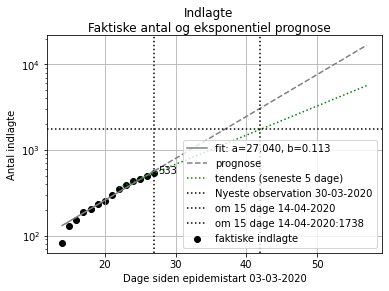

om 15 dage 14-04-2020:1738
om 30 dage 29-04-2020:5635


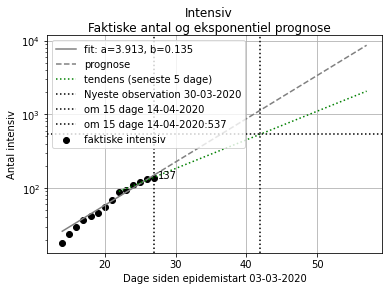

om 15 dage 14-04-2020:537
om 30 dage 29-04-2020:2059


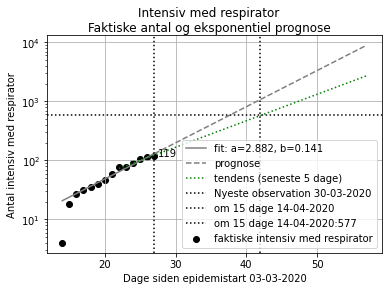

om 15 dage 14-04-2020:577
om 30 dage 29-04-2020:2719


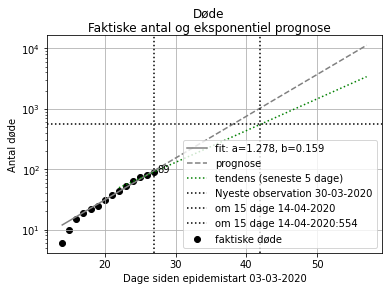

om 15 dage 14-04-2020:554
om 30 dage 29-04-2020:3410


In [12]:
f1 = 15
f2 = 30
for k in kolonner:
    a = estimater[k]['a']
    b = estimater[k]['b']
    a_tendens = estimater[k]['a_tendens']
    b_tendens = estimater[k]['b_tendens']
    y_data = estimater[k]['y_data']
    overskrift = OVERSKRIFTER[k] 

    y_data_fremskrivning = exp_func(x_data_fremskrivning, a, b)

    x_data_tendens_fremskrivning = x_data_alle[-(1+TENDENS_DAGE+FREMSKRIV_DAGE):]
    y_data_tendens_fremskrivning = exp_func(x_data_tendens_fremskrivning, a_tendens, b_tendens)
    
    plt.plot(x_data, exp_func(x_data, a, b), c='grey', ls='-', label='fit: a=%5.3f, b=%5.3f' % (a,b))
    plt.plot(x_data_fremskrivning, y_data_fremskrivning, c='grey', ls='--', label='prognose')
    plt.scatter(x_data, y_data, c='black', label=f'faktiske {overskrift.lower()}')
    plt.plot(x_data_tendens_fremskrivning, y_data_tendens_fremskrivning, c='green', ls=':', label=f'tendens (seneste {TENDENS_DAGE} dage)')
    
    nyeste_xy = (x_data.to_list()[-1] + .5, y_data.to_list()[-1])
    plt.annotate(f'{int(nyeste_xy[1])}', nyeste_xy) 
    
    plt.xlabel(f'Dage siden epidemistart {EPIDEMI_START.strftime("%d-%m-%Y")}')
    plt.ylabel(f'Antal {overskrift.lower()}')
    plt.axvline(day_N_max, color='k', linestyle=':', 
                label=f'Nyeste observation {date_max.date().strftime("%d-%m-%Y")}')
    plt.axvline(day_N_max+f1, color='k', linestyle=':', 
                label=f'om {f1} dage {(date_max+mdates.num2timedelta(f1)).date().strftime("%d-%m-%Y")}')
    plt.axhline(y_data_tendens_fremskrivning[TENDENS_DAGE+f1], color='k', linestyle=':', 
                label=f'om {f1} dage {(date_max+mdates.num2timedelta(f1)).date().strftime("%d-%m-%Y")}:{int(y_data_tendens_fremskrivning[TENDENS_DAGE+f1])}')
    plt.legend()
    plt.suptitle(f'{overskrift}\nFaktiske antal og eksponentiel prognose')
    plt.yscale('log')
    plt.grid()
    
    plt.show()
    print(f'om {f1} dage {(date_max+mdates.num2timedelta(f1)).date().strftime("%d-%m-%Y")}:{int(y_data_tendens_fremskrivning[TENDENS_DAGE+f1])}')
    print(f'om {f2} dage {(date_max+mdates.num2timedelta(f2)).date().strftime("%d-%m-%Y")}:{int(y_data_tendens_fremskrivning[TENDENS_DAGE+f2])}')
    